In [2]:
import torch
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import os,sys
#parent_path = str(Path(os.getcwd()).parent)
#sys.path.insert(1,parent_path)
from utilsCPD import *
from SWCPD import BaseDetector as SWDCP

In [3]:
df_TS = load_master_data("./datasets/has2023_master.csv.zip")


def prepare_data(df_TS,channels_start,id):
    initalized = False
    for k,name in zip(df_TS.iloc[id,channels_start:],df_TS.columns[channels_start:]):
        if np.array(k).shape[0]!=0:
            if not initalized:
                data = pd.DataFrame(k,columns=[name]).astype('float32')
                initalized = True
            else:
                data[name] = np.array(k).astype(np.float32)
    if df_TS.iloc[id].group == 'outdoor':
        data = data.iloc[:,:-3]
    GroundTruth = df_TS.iloc[id,5]

    data = (data - data.mean())/(data.std())
    return data,GroundTruth

In [5]:
IDs = [10,14,7,182,225,19,185,33,36,87,88,210,11,20,23,243,247,91,95,96,100,141,91,95,245]

METRICS_SWD = {}
for id in IDs:
    print(id)
    METRICS_SWD[id]  = {}
    df, GroundTruth = prepare_data(df_TS,8,id)
    if df.shape[0]<500:
        continue
    detector = SWDCP(data=df.to_numpy(),window_length=500,max_history=20)
    detector.process_dataloader()
    f1,Cover, AUC = detector.evaluate(GroundTruth,tolerance=100)
    METRICS_SWD[id]['F1'] =f1
    METRICS_SWD[id]['Covering'] = Cover
    METRICS_SWD[id]['AUC'] = AUC
    print(METRICS_SWD[id])


10


 15%|█▌        | 788/5098 [00:12<01:18, 54.82it/s]

Change detected at: 1281 
Initiate new segment


 73%|███████▎  | 3698/5098 [01:01<00:26, 53.19it/s]

Change detected at: 4192 
Initiate new segment


100%|██████████| 5098/5098 [01:24<00:00, 60.44it/s]


F1 score: 0.8571428571428571
Covering: 0.7366734252994743
0.875
{'F1': 0.8571428571428571, 'Covering': 0.7366734252994743, 'AUC': 0.875}
14


 43%|████▎     | 2356/5453 [00:38<00:50, 61.06it/s]

Change detected at: 2845 
Initiate new segment


 66%|██████▌   | 3607/5453 [01:00<00:30, 60.20it/s]

Change detected at: 4096 
Initiate new segment


100%|██████████| 5453/5453 [01:29<00:00, 60.75it/s]


F1 score: 0.8571428571428571
Covering: 0.7601708295222658
0.875
{'F1': 0.8571428571428571, 'Covering': 0.7601708295222658, 'AUC': 0.875}
7


 19%|█▉        | 1119/5876 [00:18<01:15, 62.81it/s]

Change detected at: 1609 
Initiate new segment
Change detected at: 1611 
Initiate new segment


 40%|████      | 2354/5876 [00:37<00:54, 64.23it/s]

Change detected at: 2841 
Initiate new segment


 62%|██████▏   | 3648/5876 [00:58<00:37, 59.76it/s]

Change detected at: 4137 
Initiate new segment


 82%|████████▏ | 4818/5876 [01:14<00:13, 79.96it/s]

Change detected at: 5301 
Initiate new segment


100%|██████████| 5876/5876 [01:28<00:00, 66.34it/s]


F1 score: 0.9090909090909091
Covering: 0.9962414805616646
0.9166666666666667
{'F1': 0.9090909090909091, 'Covering': 0.9962414805616646, 'AUC': 0.9166666666666667}
182


 42%|████▏     | 3454/8241 [00:54<01:12, 66.29it/s]

Change detected at: 3944 
Initiate new segment


 45%|████▍     | 3690/8241 [00:57<01:09, 65.58it/s]

Change detected at: 4176 
Initiate new segment


 87%|████████▋ | 7206/8241 [01:52<00:15, 64.96it/s]

Change detected at: 7693 
Initiate new segment


100%|██████████| 8241/8241 [02:09<00:00, 63.55it/s]


F1 score: 0.6666666666666665
Covering: 0.6986307937963215
0.675
{'F1': 0.6666666666666665, 'Covering': 0.6986307937963215, 'AUC': 0.675}
225


 36%|███▌      | 2394/6739 [00:38<01:10, 61.90it/s]

Change detected at: 2885 
Initiate new segment


 56%|█████▌    | 3784/6739 [01:00<00:47, 62.20it/s]

Change detected at: 4273 
Initiate new segment


 81%|████████▏ | 5484/6739 [01:28<00:20, 61.53it/s]

Change detected at: 5978 
Initiate new segment


100%|██████████| 6739/6739 [01:48<00:00, 62.36it/s]


F1 score: 0.888888888888889
Covering: 0.8021980341691818
0.9
{'F1': 0.888888888888889, 'Covering': 0.8021980341691818, 'AUC': 0.9}
19


100%|██████████| 3797/3797 [01:03<00:00, 59.69it/s]


F1 score: 0.5
Covering: 0.3339207967916108
0.6666666666666667
{'F1': 0.5, 'Covering': 0.3339207967916108, 'AUC': 0.6666666666666667}
185


 13%|█▎        | 1036/7761 [00:16<01:47, 62.85it/s]

Change detected at: 1526 
Initiate new segment


 49%|████▉     | 3832/7761 [01:00<01:04, 61.33it/s]

Change detected at: 4321 
Initiate new segment


 67%|██████▋   | 5188/7761 [01:21<00:38, 66.99it/s]

Change detected at: 5681 
Initiate new segment


 83%|████████▎ | 6439/7761 [01:41<00:21, 62.31it/s]

Change detected at: 6931 
Initiate new segment


100%|██████████| 7761/7761 [02:01<00:00, 64.09it/s]


F1 score: 0.9090909090909091
Covering: 0.8299383305375034
0.9166666666666667
{'F1': 0.9090909090909091, 'Covering': 0.8299383305375034, 'AUC': 0.9166666666666667}
33


 13%|█▎        | 935/7449 [00:15<01:46, 61.42it/s]

Change detected at: 1422 
Initiate new segment


 34%|███▍      | 2521/7449 [00:40<01:15, 65.03it/s]

Change detected at: 3007 
Initiate new segment


 52%|█████▏    | 3898/7449 [01:06<01:09, 51.20it/s]

Change detected at: 4390 
Initiate new segment


100%|██████████| 7449/7449 [02:09<00:00, 57.52it/s]


F1 score: 0.8
Covering: 0.7222343067466297
0.8333333333333333
{'F1': 0.8, 'Covering': 0.7222343067466297, 'AUC': 0.8333333333333333}
36


 11%|█         | 1061/9963 [00:19<02:28, 60.07it/s]

Change detected at: 1548 
Initiate new segment


 41%|████      | 4099/9963 [01:16<01:42, 57.16it/s]

Change detected at: 4591 
Initiate new segment


100%|██████████| 9963/9963 [03:01<00:00, 54.84it/s]


F1 score: 0.6
Covering: 0.4326497948382314
0.7142857142857142
{'F1': 0.6, 'Covering': 0.4326497948382314, 'AUC': 0.7142857142857142}
87


100%|██████████| 3062/3062 [00:53<00:00, 57.06it/s]


F1 score: 0.6666666666666666
Covering: 0.5314433619350193
0.75
{'F1': 0.6666666666666666, 'Covering': 0.5314433619350193, 'AUC': 0.75}
88


100%|██████████| 3947/3947 [01:11<00:00, 55.51it/s]


F1 score: 0.6666666666666666
Covering: 0.6193302991726175
0.75
{'F1': 0.6666666666666666, 'Covering': 0.6193302991726175, 'AUC': 0.75}
210


 34%|███▍      | 801/2361 [00:14<00:30, 51.77it/s]

Change detected at: 1291 
Initiate new segment


100%|██████████| 2361/2361 [00:43<00:00, 54.76it/s]


F1 score: 1.0
Covering: 0.9993009701375309
1.0
{'F1': 1.0, 'Covering': 0.9993009701375309, 'AUC': 1.0}
11


 35%|███▌      | 1037/2924 [00:18<00:31, 60.61it/s]

Change detected at: 1526 
Initiate new segment


100%|██████████| 2924/2924 [00:51<00:00, 56.24it/s]


F1 score: 0.8
Covering: 0.8056260760098357
0.8333333333333333
{'F1': 0.8, 'Covering': 0.8056260760098357, 'AUC': 0.8333333333333333}
20


 66%|██████▌   | 2633/4005 [00:44<00:22, 61.52it/s]

Change detected at: 3126 
Initiate new segment


100%|██████████| 4005/4005 [01:09<00:00, 57.64it/s]


Change detected at: 4499 
Initiate new segment
F1 score: 0.6666666666666666
Covering: 0.6516652149109798
0.6666666666666666
{'F1': 0.6666666666666666, 'Covering': 0.6516652149109798, 'AUC': 0.6666666666666666}
23


 42%|████▏     | 952/2282 [00:16<00:22, 58.66it/s]

Change detected at: 1444 
Initiate new segment


100%|██████████| 2282/2282 [00:40<00:00, 56.33it/s]


F1 score: 0.8
Covering: 0.7940905596617417
0.8333333333333333
{'F1': 0.8, 'Covering': 0.7940905596617417, 'AUC': 0.8333333333333333}
243


 31%|███       | 1124/3612 [00:20<00:40, 61.66it/s]

Change detected at: 1612 
Initiate new segment


 69%|██████▉   | 2486/3612 [00:44<00:21, 53.11it/s]

Change detected at: 2980 
Initiate new segment


100%|██████████| 3612/3612 [01:05<00:00, 55.11it/s]


F1 score: 1.0
Covering: 0.9990275069977558
1.0
{'F1': 1.0, 'Covering': 0.9990275069977558, 'AUC': 1.0}
247


 77%|███████▋  | 1277/1658 [00:22<00:07, 53.23it/s]

Change detected at: 1771 
Initiate new segment


100%|██████████| 1658/1658 [00:29<00:00, 55.74it/s]


F1 score: 0.8
Covering: 0.6502612405296444
0.8333333333333333
{'F1': 0.8, 'Covering': 0.6502612405296444, 'AUC': 0.8333333333333333}
91


100%|██████████| 2262/2262 [00:42<00:00, 53.42it/s]


F1 score: 1.0
Covering: 1.0
1.0
{'F1': 1.0, 'Covering': 1.0, 'AUC': 1.0}
95
96


100%|██████████| 638/638 [00:12<00:00, 52.97it/s]


F1 score: 1.0
Covering: 1.0
1.0
{'F1': 1.0, 'Covering': 1.0, 'AUC': 1.0}
100


100%|██████████| 455/455 [00:08<00:00, 50.74it/s]


F1 score: 1.0
Covering: 1.0
1.0
{'F1': 1.0, 'Covering': 1.0, 'AUC': 1.0}
141


 86%|████████▋ | 4923/5701 [01:25<00:07, 100.62it/s]

Change detected at: 5408 
Initiate new segment


100%|██████████| 5701/5701 [01:34<00:00, 60.07it/s] 


F1 score: 0.6666666666666666
Covering: 0.8722580645161291
0.75
{'F1': 0.6666666666666666, 'Covering': 0.8722580645161291, 'AUC': 0.75}
91


100%|██████████| 2262/2262 [00:28<00:00, 79.01it/s]


F1 score: 1.0
Covering: 1.0
1.0
{'F1': 1.0, 'Covering': 1.0, 'AUC': 1.0}
95
245


100%|██████████| 804/804 [00:12<00:00, 65.12it/s]

F1 score: 1.0
Covering: 1.0
1.0
{'F1': 1.0, 'Covering': 1.0, 'AUC': 1.0}


In [18]:
f1,cov,AUC = [],[],[]
for k,metrics in METRICS_SWD.items():
    if len(metrics)>1:
        f1.append(metrics['F1'])
        cov.append(metrics['Covering'])
        AUC.append(metrics['AUC'])

print(np.mean(f1))
print(np.mean(cov))
print(np.mean(AUC))

0.8206677161222617
0.7834391402788244
0.8540584415584417


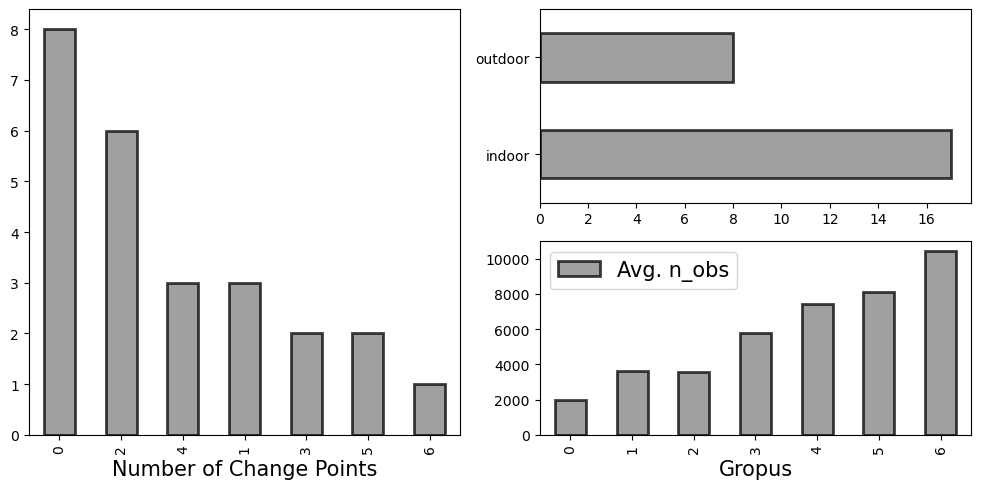

In [400]:
from matplotlib.pyplot import GridSpec
groups = []
ind_out = []
lengths = []
for id in IDs:
    groups.append(len(df_TS.iloc[id].change_points))
    ind_out.append(df_TS.iloc[id].group)
    lengths.append(df_TS.iloc[id]['x-acc'].shape[0])



fig = plt.figure(figsize=(10,5))

gs = GridSpec(2,2)

ax1 = fig.add_subplot(gs[:, 0])
pd_plot1 = pd.Series(groups).value_counts()
pd_plot1.plot(kind='bar',edgecolor='black',color='grey',alpha=0.75,lw=2,ax=ax1)
ax1.set_xlabel('Number of Change Points',fontsize=15)
ax2 = fig.add_subplot(gs[:1, 1])
pd.Series(ind_out).value_counts().plot(kind='barh',edgecolor='black',color='grey',alpha=0.75,lw=2,ax=ax2)
ax3 = fig.add_subplot(gs[1:,1])

df_plot3 = pd.DataFrame({'groups':groups,'n_obs':lengths}).groupby(['groups']).mean()
df_plot3.columns.values[0] = 'Avg. n_obs'
df_plot3.plot(kind='bar',ax=ax3,legend=False,edgecolor='black',color='grey',alpha=0.75,lw=2)
ax3.legend(fontsize=15)
ax3.set_xlabel('Gropus',fontsize=15)
fig.tight_layout()

In [401]:
fig.savefig('HASC_appendix_analysis.pdf')

In [12]:
from claspy.segmentation import BinaryClaSPSegmentation
from claspy.data_loader import load_has_dataset
df_TS_CL = load_has_dataset()

In [ ]:
METRICS = {}
IDs = [10,14,7,182,225,19,185,33,36,87,88,210,11,20,23,243,247,91,95,96,100,141,91,95,245]

for id in IDs:
    print(id)
    METRICS[id]  = {}

    dataset, window_size, true_cps,labels, time_series = df_TS_CL.iloc[id,:]

    clasp = BinaryClaSPSegmentation(window_size=window_size).fit(time_series)
    f1,AUC_run = f_measure({'0':true_cps},clasp.change_points,100)
    METRICS[id]['F1'] = f1
    METRICS[id]['AUC'] = AUC_run
    METRICS[id]['Covering'] = covering({'0':true_cps},clasp.change_points,time_series.shape[0])

   

10
0.6666666666666666
0.47362938777338753
14
0.8
0.8147039545873119
7
1.0
0.9608166258723849
182
0.8333333333333333
0.8337458823596751
225
0.8000000000000002
0.8889321183710303
19
0.5
0.3339207967916108
185
0.3333333333333333
0.7536165086029252
33
0.923076923076923
0.9143636350134828
36
0.8333333333333333
0.6864314899996291
87
0.6666666666666666
0.6686324066273519
88
0.8
0.6270406599128661
210
1.0
0.9958139083139084
11
0.8
0.7932636738020196
20
0.7499999999999999
0.782645504781384
23
0.8571428571428571
0.7121560476078309
243
0.8
0.6898923340070571
247
0.8
0.6292284958231936
91
1.0
1.0
95
1.0
1.0
96
1.0
1.0
100
1.0
1.0
141


c:\Users\Sven Jacob\miniconda3\envs\torch\Lib\site-packages\claspy\segmentation.py:212: UserWarning: Time series must at least have 2*min_seg_size data points for segmentation. Try setting a smaller window size.
  warnings.warn(


0.6666666666666666
0.9230645161290323
91
1.0
1.0
95
1.0
1.0
245
0.6666666666666666
0.6446661550268611


c:\Users\Sven Jacob\miniconda3\envs\torch\Lib\site-packages\claspy\segmentation.py:212: UserWarning: Time series must at least have 2*min_seg_size data points for segmentation. Try setting a smaller window size.
  warnings.warn(


In [19]:
f1,cov, AUC = [],[], []
for k,metrics in METRICS.items():
    f1.append(metrics['F1'])
    cov.append(metrics['Covering'])
    AUC.append(metrics['AUC'])

print(np.mean(f1))
print(np.mean(cov))
print(np.std(AUC))


0.8042124542124544
0.7881114826696931
0.14533031504503635


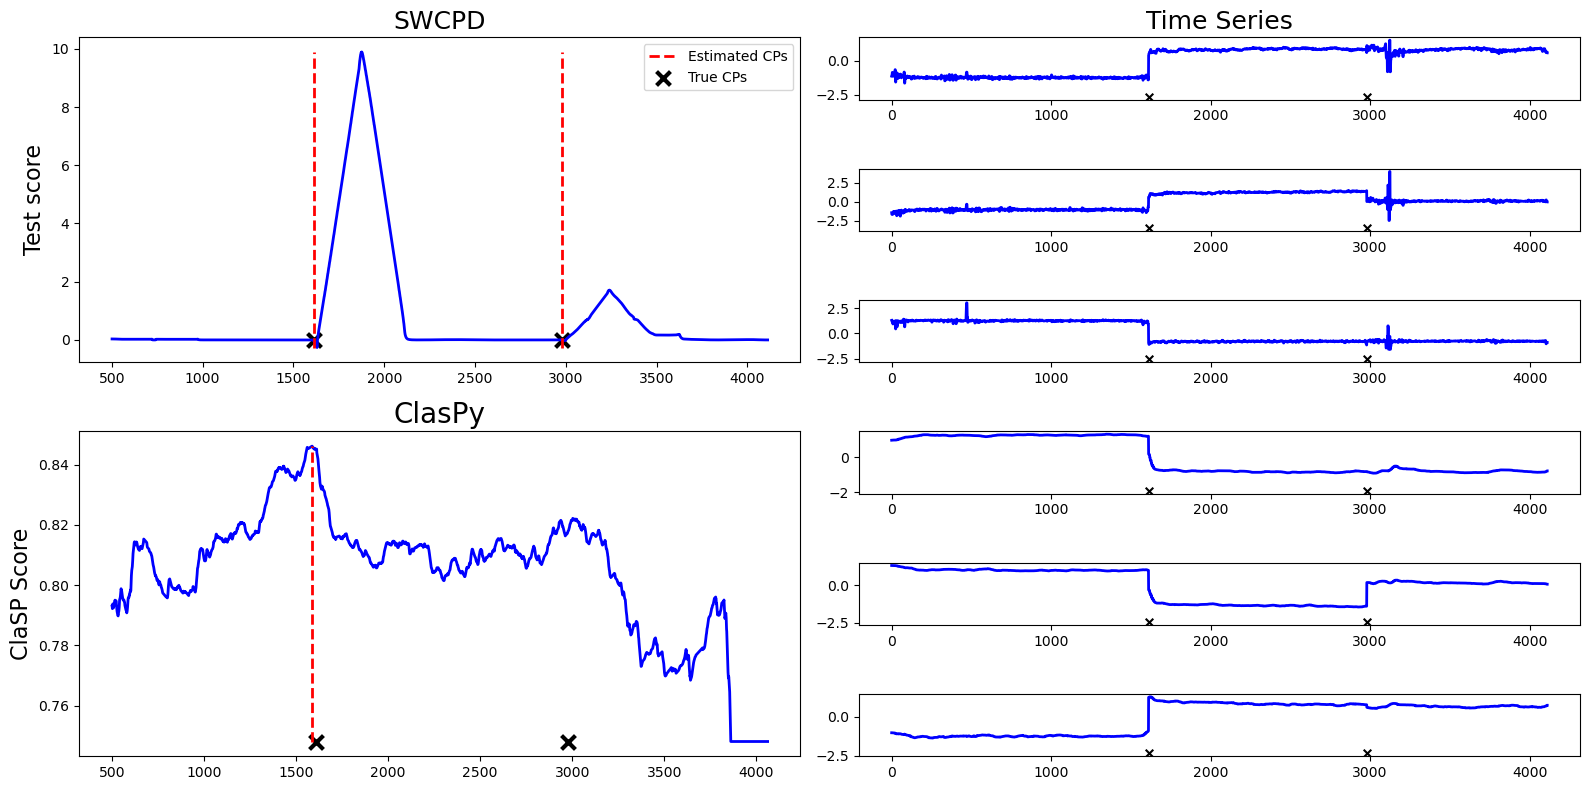

In [209]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
from matplotlib.ticker import FuncFormatter


fig = plt.figure(figsize=(16, 8))
gs = GridSpec(df.shape[1],2)



ax1 = fig.add_subplot(gs[0:df.shape[1]//2, 0])  # Top half of the first column
ax1.set_title('SWCPD',fontsize=18)
test_stat = np.subtract(detector.upper[:-1],detector.cumsum[1:])
ax1.plot(t,test_stat,alpha=1,lw=2,color='blue')
ax1.vlines(np.array(detector.change_points['loc']),min(test_stat),max(test_stat),color='red',alpha=1.0,lw=2,ls='--',label='Estimated CPs')
ax1.scatter(GroundTruth,np.zeros(len(GroundTruth)),marker='x',color='black',s=100,linewidth=3,label='True CPs')
ax1.set_ylabel('Test score',fontsize=16)
ax1.legend(loc='upper right')

ax2 = fig.add_subplot(gs[df.shape[1]//2:, 0])  # Top half of the first colum
ax2.set_title('ClasPy',fontsize=20)
#ax2.plot(np.arange(clasp.profile.shape[0]),clasp.profile,color='blue',lw=0.75)
ax2.plot(t[:-window_size],clasp.profile[t[:-window_size]],color='blue',lw=2)
ax2.scatter(GroundTruth,np.min(clasp.profile)*np.ones(len(GroundTruth)),marker='x',color='black',s=100,linewidth=3)
ax2.vlines(clasp.change_points,np.min(clasp.profile),np.max(clasp.profile),color='red',lw=2,ls='--')
#ax2.plot(clasp.change_points,np.min(clasp.profile)*np.ones(len(clasp.change_points)),'o',color='red',ms=4)
#ax2.set_xlabel('Time')
ax2.set_ylabel('ClaSP Score',fontsize=16)
ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.2f}"))


#### fill out right hand side

for i in range(df.shape[1]):
    ax = fig.add_subplot(gs[i, 1])  
    ax.plot(df.iloc[:,i].values,lw=2,color='blue',alpha=1)
    ax.scatter(GroundTruth,(np.min(df.iloc[:,i]-1))*np.ones(len(GroundTruth)),marker='x',color='black',s=30,alpha=1)
    if i == 0: 
        ax.set_title('Time Series',fontsize=18)

fig.tight_layout()


In [210]:
fig.savefig('HASC_TS_243.pdf')

In [213]:
"HASC_TS_"+str(id)+".csv"

'HASC_TS_243.csv'

In [28]:
BinaryClaSPSegmentation()

'c:\\Users\\Sven Jacob\\Documents\\Github\\SWDCPD\\Appendix'

In [404]:
for id in IDs:
    df_exp, cps = prepare_data(df_TS,8,id)
    df_exp.to_csv("HASC_TS_"+str(id)+".csv")